In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import os
import seaborn as sns
# Load imports from git directory
import pairwise_functions as pf

In [2]:
def plot_heatmap(passing_cells_df, title = "", min_col_n=10, min_row_n=10, row_clust = "cell_type_prediction", columns_clust = None, scale_by_col = True, min_value_for_label=5, sort_alpha_numerically=False, show_vert_lines=False, show_horizontal_lines=False, is_wide = False):

# create heatmap of variable "cluster_alias" and "cell_type_prediction"
    if not is_wide:
        passing_cells_df = passing_cells_df[[row_clust, columns_clust]]
        pivot_df = passing_cells_df.pivot_table(index=row_clust, columns=columns_clust, aggfunc=len, fill_value=0)
    else:
        pivot_df = passing_cells_df

    # if column has less than n cells, remove it
    pivot_df = pivot_df.loc[:, pivot_df.sum(axis=0) > min_col_n]
    # if row has less than n cells, remove it
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1) > min_row_n, :]

    pivot_df.sort_index(inplace=True, axis=1, ascending=True)

    # if scaling by columns 
    if not sort_alpha_numerically:
        if scale_by_col:
            max_index = pivot_df.idxmax(axis=0)
            max_index = max_index.sort_values()
            pivot_df = pivot_df[max_index.index]
        else:
            max_index = pivot_df.idxmax(axis=1)
            max_index = max_index.sort_values()
            pivot_df = pivot_df.loc[max_index.index]
    else:
        #sort pivot_df index in place
        pivot_df.sort_index(inplace=True, axis=0, ascending=False)
    annot_mask = np.where(pivot_df > min_value_for_label, pivot_df.astype(str), "")


    # scale by column
    if scale_by_col:
        pivot_df = pivot_df.div(pivot_df.sum(axis=0), axis=1)
    else:
        pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    plt.figure(figsize=(30, 20))
    sns.heatmap(pivot_df, cmap="viridis", xticklabels=True, yticklabels=True, cbar=True)
    # sns.heatmap(pivot_df, cmap="viridis", cbar=False)
    # rotate x axis labels 45 degrees
    plt.title(title)
    x_tick_options = {"fontsize": "large"}
    plt.xticks(ha="center", **x_tick_options)
    y_ticks_options = {"fontsize": "large"}
    plt.yticks(**y_ticks_options)

    # Add vertical lines to show separation between ticks
    if show_vert_lines:
        alternating_colors = ["white",  "orange", "yellow", "pink"]
        n_colors = len(alternating_colors)
        for i in range(len(pivot_df.columns)):
            current_color = alternating_colors[i % n_colors]
            plt.axvline(i, color=current_color, linewidth=0.5)

    if show_horizontal_lines:
        alternating_colors = ["white",  "orange", "yellow", "pink"]
        n_colors = len(alternating_colors)
        for i in range(len(pivot_df.index)):
            current_color = alternating_colors[i % n_colors]
            plt.axhline(i, color=current_color, linewidth=0.5)

    plt.show()
    return pivot_df

def v1_in_v2(v1, v2):
    out = np.empty(v1.shape[0],dtype=np.bool_)
    present_set=set(v2)
    for i in range(v1.shape[0]):
        if v1[i] in present_set:
            out[i]=True
        else:
            out[i]=False
    return out

# Load Example Reference

In [3]:
obj = ad.read_h5ad("small_macosko_ref.h5ad")

os.makedirs("pknn_example_dir", exist_ok=True)


# Chunk Reference

In [4]:
n_samples_per_obj = 200
chunked_out_base = os.path.abspath("pknn_example_dir/chunked_objs")
cell_type_col="ClusterNm"


In [5]:

os.makedirs(chunked_out_base, exist_ok=True)
unique_cell_types = obj.obs[cell_type_col].unique()
gene_names = np.array(obj.var_names).flatten()


result_lis = []
cell_type_lis = []

for inx, cell_type in enumerate(unique_cell_types):
    if inx % 10 == 0:
        print(inx)

    is_ct = obj.obs[cell_type_col] == cell_type
    indices = np.array(np.where(is_ct)).flatten()
    n_to_sample = np.min([len(indices), n_samples_per_obj])
    sampled_indices = np.random.choice(a=indices, size=n_to_sample, replace=False)

    sampling_bool = np.zeros(obj.shape[0]).astype(bool)    
    sampling_bool[sampled_indices] = True

    sub_obj = obj[sampling_bool]

    ct_out_path = os.path.join(chunked_out_base, f"{cell_type}.h5ad")
    sub_obj.write_h5ad(ct_out_path)

0
10


# Select Markers

In [5]:
n_markers_dir = 25
chunked_out_base

markers_out_path = "pknn_example_dir/diff_markers_chunked"
markers_out_path_full = os.path.abspath(markers_out_path)


In [9]:
valid_markers_set=None
# make sure the directory exists
os.makedirs(markers_out_path_full, exist_ok=True)

chunked_objs_present = os.listdir(chunked_out_base)
cell_types_present = [fname.split(".h5ad")[0] for fname in chunked_objs_present]

de_args = []
for inx_1, ct_name_1 in enumerate(cell_types_present):
    cell_type_2_lis = cell_types_present[inx_1 + 1:]
    arg = (chunked_out_base, ct_name_1, cell_type_2_lis, n_markers_dir, markers_out_path_full, "balanced_mean")
    de_args.append(arg)



n_cores = 2
pool = mp.Pool(n_cores)
pool.starmap(pf.compute_markers_cell_type_to_all, de_args)
pool.close()
pool.join()


Pairwise classifiers can now be fit, combining the computed markers and chunked objects

In [6]:


classifier_out_path = os.path.abspath("pknn_example_dir/classifiers")
os.makedirs(classifier_out_path, exist_ok=True)
n_features_directional=25
cell_per_type=200
equal_size_n=False


In [7]:
import re
import pdb


In [10]:
chunked_objs_present = os.listdir(chunked_out_base)
cell_types = [obj_fname.split(".h5ad")[0] for obj_fname in chunked_objs_present]

n_cores = 2
args_create_knn = [(inx, cell_type, cell_types[inx+1:], chunked_out_base,
                    markers_out_path_full, classifier_out_path,n_features_directional, cell_per_type, equal_size_n) for inx, cell_type in enumerate(cell_types)]

pool = mp.Pool(n_cores)
pool.starmap(pf.create_classifier_set_non_donor_split, args_create_knn)
pool.close()
pool.join()



Working on inx: 0
Working on inx: 10


Create subsampled reference to initially place cells

If the reference type has excess cells for a type, they are held out as a test set. 

In [11]:
# Want to hold some cells from each cell type for testing
np.random.seed(42)

max_ref = 50
max_query=30
min_size_to_use=20

In [12]:

cell_type_names, sizes = np.unique(obj.obs[cell_type_col], return_counts=True)
n_cell_types = len(cell_type_names)

ref_indices = []
query_indices = []

types_passing = []
types_too_small = []
for inx, (cell_type, size) in enumerate(zip(cell_type_names, sizes)):
    # track progress
    if inx % 10 == 0:
        print(inx)
         
    if size < min_size_to_use:
        types_too_small.append(cell_type)
        continue
    types_passing.append(cell_type)


    size_for_ref = min([max_ref, size])
    is_cell_type_bool = obj.obs[cell_type_col] == cell_type
    indices_for_cell_type = np.where(is_cell_type_bool)[0]

    # take a random sample of the indices
    indices_for_ref = np.random.choice(indices_for_cell_type, size_for_ref, replace=False)
    ref_indices.extend(list(indices_for_ref))
    is_cell_type_bool.iloc[indices_for_ref] = False

    excess_cells = size - size_for_ref

    if excess_cells > 10:
        size_for_query = min(excess_cells, max_query)
        
        indices_possible_query_sample = np.where(is_cell_type_bool)[0]
        indices_for_query = np.random.choice(indices_possible_query_sample, size_for_query, replace=False)
    
        query_indices.extend(list(indices_for_query))


0
10


In [13]:
query_obj = obj[query_indices]
ref_obj = obj[ref_indices]

assert len(set(query_obj.obs_names).intersection(ref_obj.obs_names)) == 0

Test predictions on query cells

In [14]:
chunked_reference_base="pknn_example_dir/chunked_objs"

classifier_out_path = "pknn_example_dir/classifiers"

n_neighbors_h0=10
n_next_cell_types_compare=10
models_are_folder_chunked=True

In [15]:
#assert that genes match
assert all(ref_obj.var.index == query_obj.var.index), "Genes do not match"
query_obj.obs["source"] = "query"
ref_obj.obs["source"] = "reference"

### Combine Objects and Run Clustering Workflow to create intial embedding###
print("Combining objects and running clustering workflow")


combined_obj = ad.concat([query_obj, ref_obj], join="outer")
combined_obj = pf.run_clustering_workflow(combined_obj)

print("Running pknn")


/tmp/ipykernel_4844/2133105949.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  query_obj.obs["source"] = "query"
/tmp/ipykernel_4844/2133105949.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ref_obj.obs["source"] = "reference"


Combining objects and running clustering workflow
Normalizing and log transforming
Finding variable genes
Filtering to highly variable genes
AnnData object with n_obs × n_vars = 1409 × 4000
    obs: 'ClusterKey', 'ClusterNm', 'derived_cell_libs', 'class', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Scaling data
Running PCA
Running pknn


In [16]:
pairwise_pred_results = pf.preform_pairwise_knn_prediction(model_path=classifier_out_path, n_neighbors_h0 = n_neighbors_h0, query_obj = query_obj, combined_obj = combined_obj, n_next_cell_types_compare=n_next_cell_types_compare, n_cores = 2, embed_key="X_pca", models_are_folder_chunked=models_are_folder_chunked, ref_ct_label=cell_type_col)


Running n_groups comparisons for cellular predictions. n_next_cell_types_compare provided.
Thu Dec  5 19:31:15 2024
Building knn graph for reference data.
Running knn classifier for query data. k = 500
Parsing knn results. Establish future comparisons
0
Thu Dec  5 19:31:15 2024
Converting query to dense. Will spike memory.
Constructing args
Beginning parallel processing
0
Thu Dec  5 19:31:19 2024
Parsing first round results
Thu Dec  5 19:31:19 2024
Running secondary comparisons
Constructing args for 21 cell type comparisons
0
Thu Dec  5 19:31:19 2024
Seconary results done
Thu Dec  5 19:31:19 2024
Parsing combined results
0
Thu Dec  5 19:31:19 2024


/tmp/ipykernel_4844/2263017129.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = passing_cells_df.pivot_table(index=row_clust, columns=columns_clust, aggfunc=len, fill_value=0)


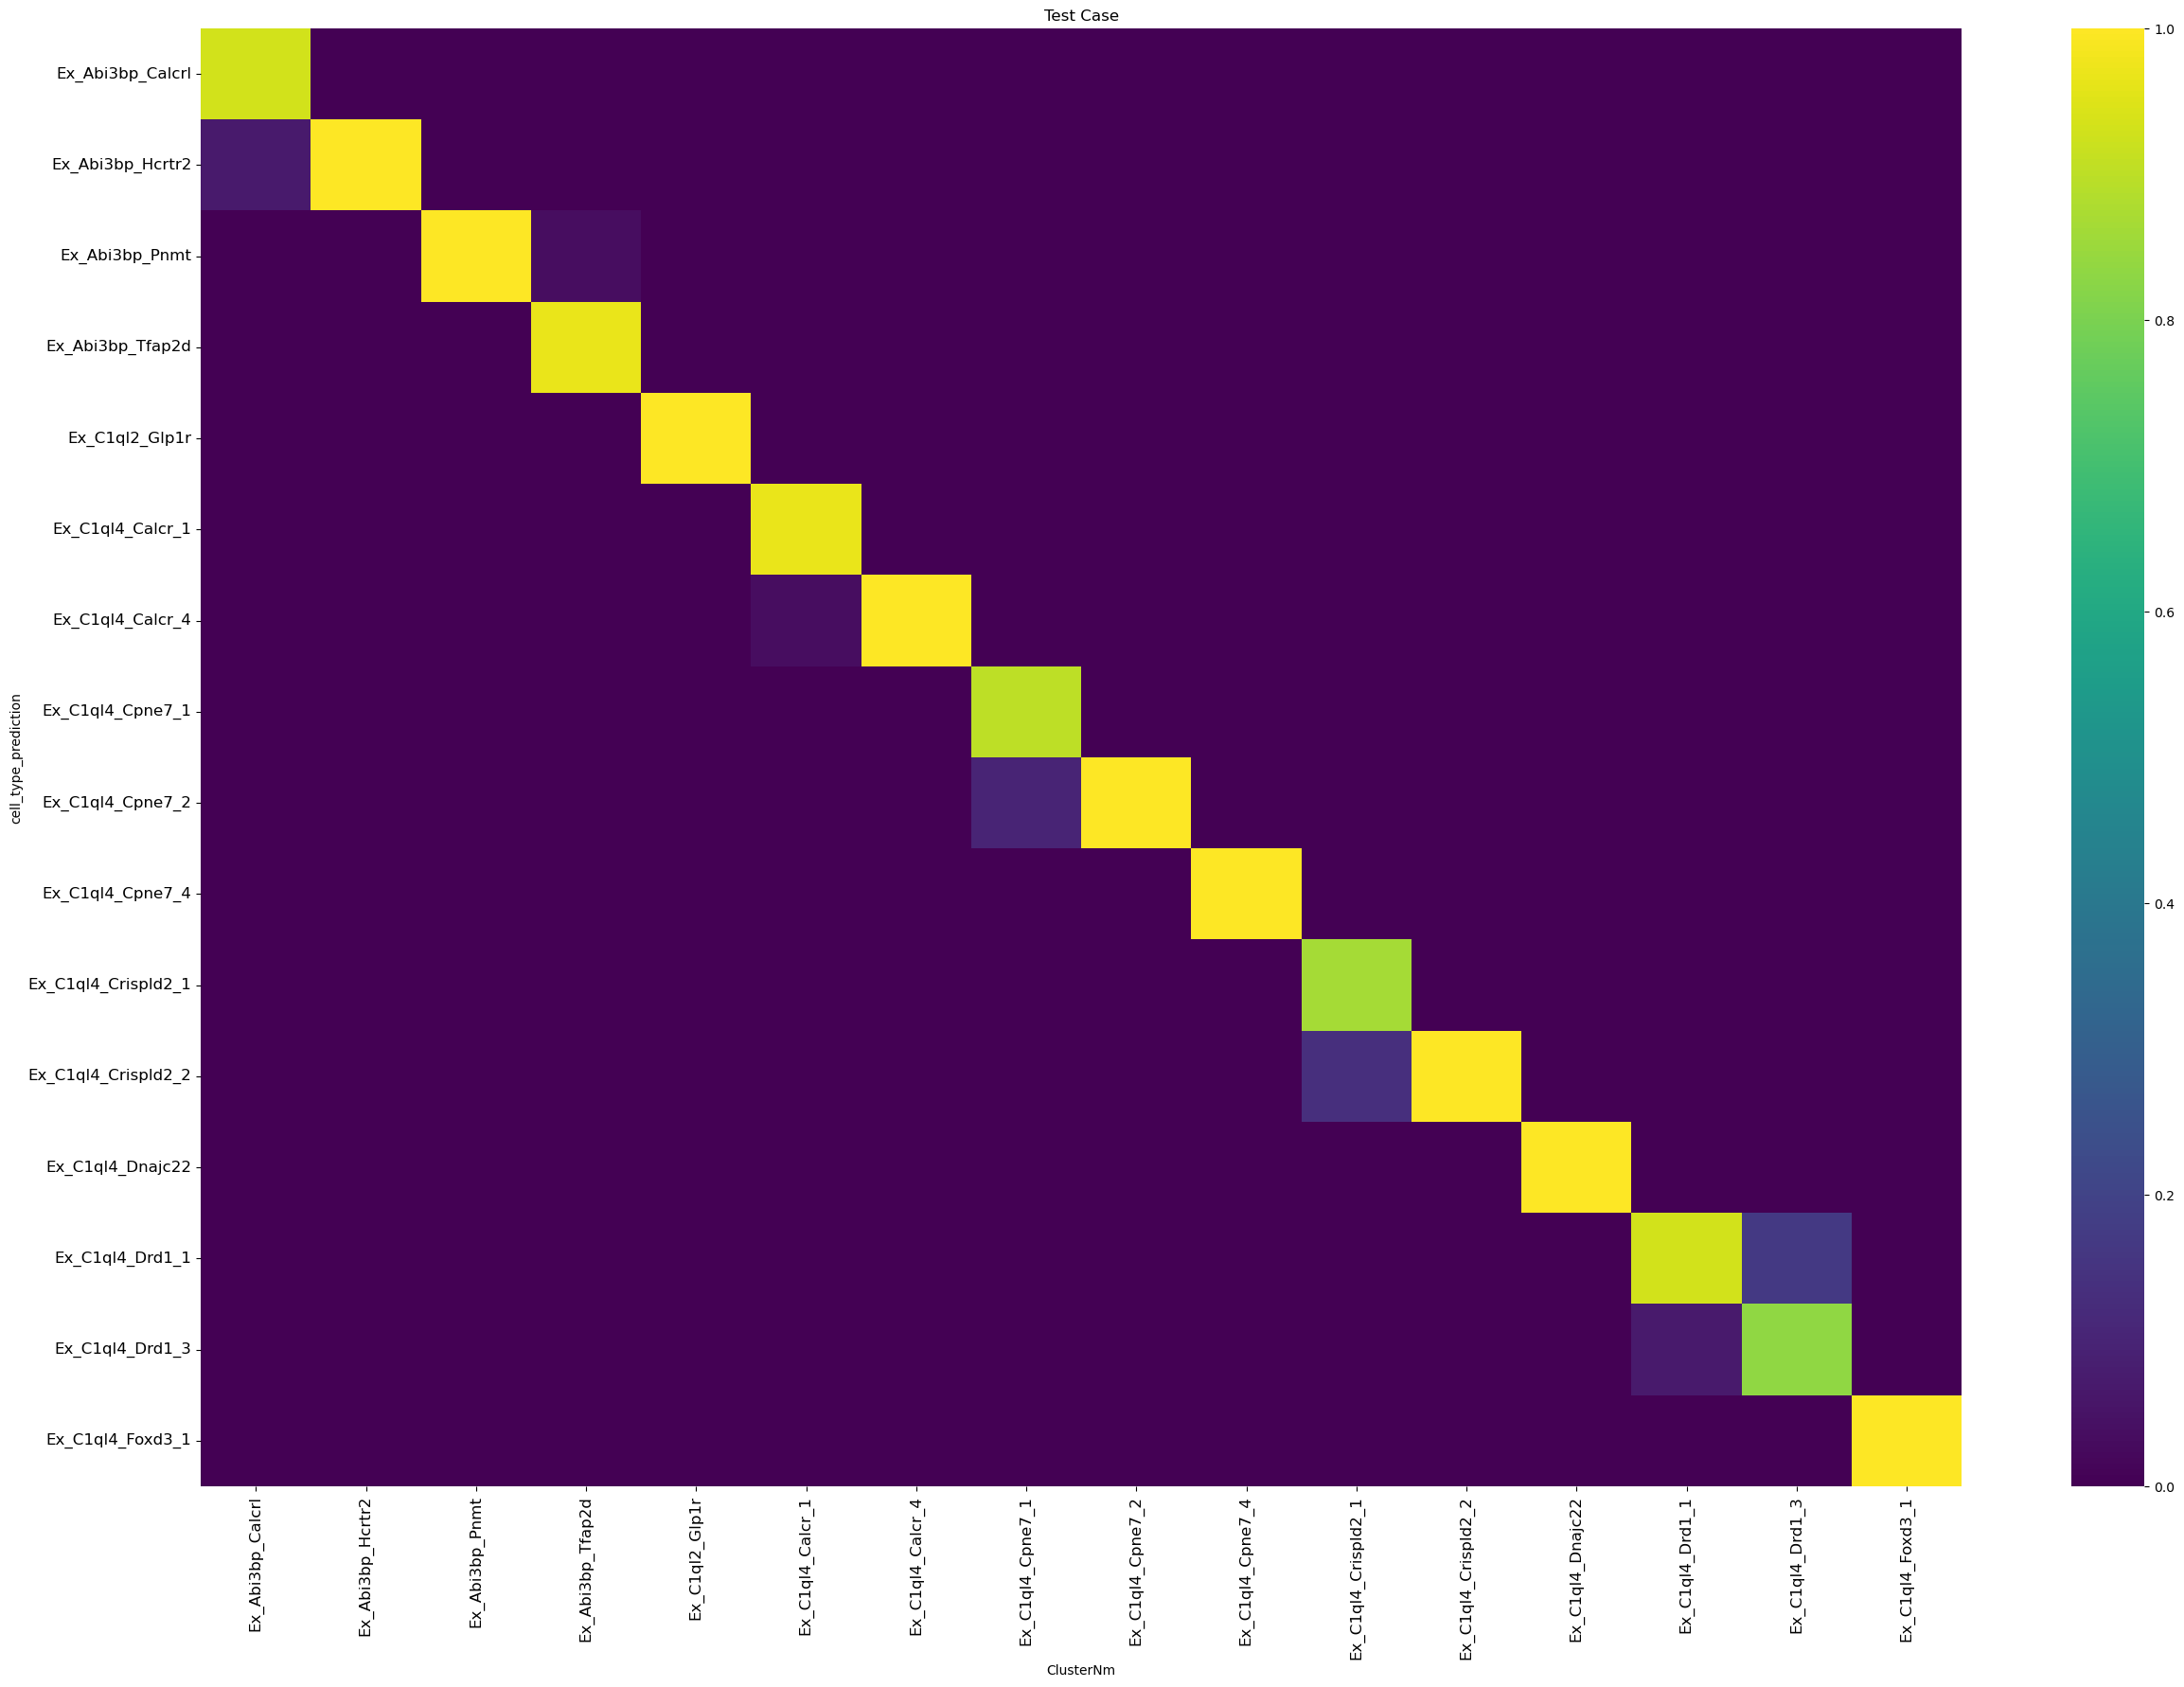

In [17]:
result_df = pairwise_pred_results["cellular_prediction_df"]
query_meta = query_obj.obs

merged_meta = pd.merge(result_df, query_meta, right_index=True, left_index=True)
match_rate = np.mean(merged_meta["cell_type_prediction"] == merged_meta[cell_type_col])

result_df_passing = result_df.loc[result_df["pass_rate"] == 1]
merged_meta_passing = pd.merge(result_df_passing, query_meta, right_index=True, left_index=True, how="inner")

match_rate_passing= np.mean(merged_meta_passing["cell_type_prediction"] == merged_meta_passing[cell_type_col])
_ = plot_heatmap(merged_meta, title="Test Case", columns_clust=cell_type_col,min_value_for_label=0, min_col_n=0, min_row_n=0)